### Introduction

Each bag contains a fixed number of MNIST digits (e.g., 10). Each digit belongs to a class (0–9), and the bag label is determined based on the digits using one of the specific logical rules.

**Instance:** One MNIST digit image.

**Bag**: A collection of digits (e.g., a list of 10 MNIST digits).

**Label:** Positive, if, for example, a bag contains some key digit (e.g., 3), otherwise negative.

**Key instance:** A key digit image.

### Logic-Based Labeling Rules

🟢 **OR Setting: Easy** 

The bag is positive if at least one instance belongs to a target class (e.g., digit 3).

* Bag Label = 1 if any digit in the bag is a 3

* Key instance = any one of the 3s (all of them are “valid” keys)

**Intuition:** Easy, similar to classic MIL assumption.

**Example:**
Bag = [1, 5, 7, 3, 0] → Label = 1 / Key instance: 7
  
🔴 **AND Setting: Medium**

The bag is positive only if all instances satisfy a condition (e.g., 3 and 7 should be presented at the same time).  
* Bag Label = 1 if 3 and 7 are in the bug at the same time.  
* Key instance = 3 and 7; if only one is presented, label = 0.

**Intuition:** Harder than OR, no single key; the absence of a “bad” instance is important

**Example:**  
Bag = [0, 3, 4, 6, 7] → Label = 1 / Key instances: 3 and 7  
Bag = [0, 3, 3, 6, 8] → Label = 0

🟡 **XOR Setting: Hard**

The bag is positive if an odd number of target class instances are present.

* Bag Label = 1 if there's 3 but not 7.  
* Key instance = The exact configuration matters — it’s not about presence alone, but count.

**Intuition:** Very hard — label depends on interactions between instances

**Example:**  
Bag = [1, 3, 7, 2] → Label = 0 (3 and 7 at the same time)  
Bag = [1, 3, 6, 2] → Label = 1 (only 3 but not 7) / Key instances: 3  
Bag = [1, 5, 7, 2] → Label = 1 (only 7 but not 3) / Key instances: 7    

In [1]:
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# MNIST dataset creation
from milearn.data.mnist import load_mnist, create_bags_or, create_bags_and, create_bags_xor
from milearn.network.module.utils import set_seed

# MIL classifiers
from milearn.network.classifier import (AttentionNetworkClassifier,
                                        TempAttentionNetworkClassifier,
                                        GatedAttentionNetworkClassifier,
                                        MultiHeadAttentionNetworkClassifier,
                                        SelfAttentionNetworkClassifier,
                                        HopfieldAttentionNetworkClassifier,
                                        DynamicPoolingNetworkClassifier)

# Utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from milearn.preprocessing import BagMinMaxScaler

# Prediction visualisation
from milearn.data.mnist import visualize_bag_with_weights

/home/dmitry/miniforge3/envs/mlrn/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Key Instance Detection Accuracy Functions

These functions evaluate how well a model's predicted attention weights or importance scores match the true key instance indices in positive bags, according to the logic used during bag labeling.

Each function returns a fraction of correctly identified positive bags, based on whether at least one (OR), all (AND), or exactly one (XOR) of the true key instances are recovered among the top-k predicted instances.

In [2]:
def kid_accuracy_or(key_indices, predicted_weights, bag_labels, top_k=1):
    
    correct, total = 0, 0
    for weights, keys, label in zip(predicted_weights, key_indices, bag_labels):
        if label == 1:
            pred_top_k = np.argsort(weights)[-top_k:]
            if any(idx in pred_top_k for idx in keys):
                correct += 1
            total += 1

    return correct / total if total > 0 else 0.0

def kid_accuracy_and(key_indices, predicted_weights, bag_labels, top_k=2):
    
    correct, total = 0, 0
    for weights, keys, label in zip(predicted_weights, key_indices, bag_labels):
        if label == 1:
            pred_top_k = set(np.argsort(weights)[-top_k:])
            if all(k in pred_top_k for k in keys):
                correct += 1
            total += 1

    return correct / total if total > 0 else 0.0

def kid_accuracy_xor(key_indices, predicted_weights, bag_labels, top_k=1):
    
    correct, total = 0, 0
    for weights, keys, label in zip(predicted_weights, key_indices, bag_labels):
        if label == 1:
            pred_top_k = np.argsort(weights)[-top_k:]
            match_count = sum(idx in pred_top_k for idx in keys)
            if match_count == 1:
                correct += 1
            total += 1

    return correct / total if total > 0 else 0.0

### 1. Create MNIST dataset

In [3]:
bag_size = 10
num_bags = 1000
setting_type = "or"

data, targets = load_mnist()
if setting_type == "or":
    bags, labels, key = create_bags_or(data, targets, bag_size=bag_size, num_bags=num_bags, key_digit=3, key_instances_per_bag=1, random_state=42)
    kid_accuracy = kid_accuracy_or
elif setting_type == "and":
    bags, labels, key = create_bags_and(data, targets,  bag_size=bag_size, num_bags=num_bags, key_digits=(3, 7), random_state=42)
    kid_accuracy = kid_accuracy_and
elif setting_type == "xor":
    bags, labels, key = create_bags_xor(data, targets, bag_size=bag_size, num_bags=num_bags, key_digits=(3, 7), random_state=42)
    kid_accuracy = kid_accuracy_xor

### 2. Build model

In [4]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64,),
                   'num_epoch':300,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [5]:
x_train, x_test, y_train, y_test, key_train, key_test = train_test_split(bags, labels, key, random_state=42)

In [6]:
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
model = AttentionNetworkClassifier(**network_hparams)
model.to("cpu")
model.fit(x_train_scaled, y_train)

AttentionNetworkClassifier(
  (extractor): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (detector): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (estimator): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
y_prob = model.predict(x_test_scaled)
y_pred = np.where(y_prob > 0.5, 1, 0)
w_pred = model.get_instance_weights(x_test_scaled)

In [9]:
print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"KID accuracy: {kid_accuracy(key_test, w_pred, y_test):.2f}")

Classification accuracy: 0.84
KID accuracy: 0.86


In [10]:
# bags with correct positive class prediction (use these indexes for visualization)
np.where((y_pred == 1) & (np.array(y_test) == 1))[0]

array([  1,   6,  16,  21,  22,  26,  27,  30,  31,  33,  40,  41,  43,
        45,  49,  50,  51,  52,  53,  58,  59,  60,  61,  63,  66,  67,
        69,  73,  74,  76,  78,  79,  81,  84,  87,  88,  91,  95,  97,
        98,  99, 100, 103, 106, 107, 108, 110, 112, 116, 117, 119, 121,
       123, 124, 126, 127, 129, 130, 132, 136, 142, 143, 144, 145, 151,
       153, 155, 159, 160, 162, 164, 165, 166, 169, 170, 171, 173, 174,
       176, 177, 181, 182, 184, 195, 201, 202, 207, 208, 209, 212, 213,
       220, 224, 226, 241, 242, 243, 246, 248, 249])

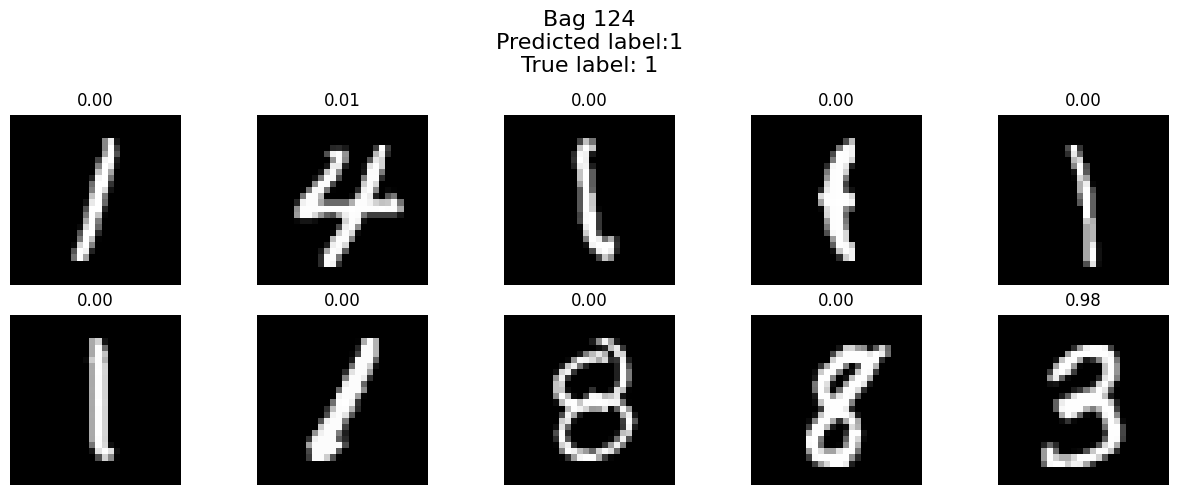

In [11]:
N = 124
visualize_bag_with_weights(x_test[N], w_pred[N], 
                           title=f"Bag {N}\nPredicted label:{y_pred[N].item()}\nTrue label: {y_test[N]}")

### 3. KID benchmark

In [12]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64),
                   'num_epoch':300,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [13]:
network_list = [
                ("AttentionNetworkClassifier", AttentionNetworkClassifier(**network_hparams)), 
                ("TempAttentionNetworkClassifier", TempAttentionNetworkClassifier(**network_hparams, tau=0.5)), 
                ("GatedAttentionNetworkClassifier", GatedAttentionNetworkClassifier(**network_hparams)), 
                ("MultiHeadAttentionNetworkClassifier", MultiHeadAttentionNetworkClassifier(**network_hparams, num_heads=10)), 
                ("SelfAttentionNetworkClassifier", SelfAttentionNetworkClassifier(**network_hparams)), 
                ("HopfieldAttentionNetworkClassifier", HopfieldAttentionNetworkClassifier(**network_hparams, beta=1)),
                ("DynamicPoolingNetworkClassifier", DynamicPoolingNetworkClassifier(**network_hparams)),
               ]

In [14]:
bag_size = 5
num_bags = 10000

data, targets = load_mnist()

res_df = pd.DataFrame()
for task_idx, task in enumerate(["or", "and", "xor"], 1):
    print(f"\n[Task {task_idx}/3] Starting task: '{task}'")

    # create dataset
    if task == "or":
        bags, labels, key = create_bags_or(data, targets, bag_size=bag_size, num_bags=num_bags, key_digit=3, key_instances_per_bag=1)
        kid_accuracy = kid_accuracy_or
    elif task == "and":
        bags, labels, key = create_bags_and(data, targets,  bag_size=bag_size, num_bags=num_bags, key_digits=(3, 7))
        kid_accuracy = kid_accuracy_and
    elif task == "xor":
        bags, labels, key = create_bags_xor(data, targets, bag_size=bag_size, num_bags=num_bags, key_digits=(3, 7))
        kid_accuracy = kid_accuracy_xor

    # prepare data
    x_train, x_test, y_train, y_test, key_train, key_test = train_test_split(bags, labels, key, random_state=42)
    scaler = BagMinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)

    # build models
    for model_idx, (name, model) in enumerate(network_list, 1):
        print(f"  [Model {model_idx}/{len(network_list)}] Training model: '{name}' for task '{task}'")

        # train model
        model.to("cpu")
        model.fit(x_train_scaled, y_train)
        # predict
        y_prob = model.predict(x_test_scaled)
        y_pred = np.where(y_prob > 0.5, 1, 0)
        w_pred = model.get_instance_weights(x_test_scaled)
        #
        res_df.loc[name, f"PRED_{task}"] = accuracy_score(y_test, y_pred)
        res_df.loc[name, f"KID_{task}"] = kid_accuracy(key_test, w_pred, y_test)

print("\nAll tasks and models completed.")


[Task 1/3] Starting task: 'or'
  [Model 1/7] Training model: 'AttentionNetworkClassifier' for task 'or'
  [Model 2/7] Training model: 'TempAttentionNetworkClassifier' for task 'or'
  [Model 3/7] Training model: 'GatedAttentionNetworkClassifier' for task 'or'
  [Model 4/7] Training model: 'MultiHeadAttentionNetworkClassifier' for task 'or'
  [Model 5/7] Training model: 'SelfAttentionNetworkClassifier' for task 'or'
  [Model 6/7] Training model: 'HopfieldAttentionNetworkClassifier' for task 'or'
  [Model 7/7] Training model: 'DynamicPoolingNetworkClassifier' for task 'or'

[Task 2/3] Starting task: 'and'
  [Model 1/7] Training model: 'AttentionNetworkClassifier' for task 'and'
  [Model 2/7] Training model: 'TempAttentionNetworkClassifier' for task 'and'
  [Model 3/7] Training model: 'GatedAttentionNetworkClassifier' for task 'and'
  [Model 4/7] Training model: 'MultiHeadAttentionNetworkClassifier' for task 'and'
  [Model 5/7] Training model: 'SelfAttentionNetworkClassifier' for task 'an

In [15]:
res_df.round(2)

,PRED_or,KID_or,PRED_and,KID_and,PRED_xor,KID_xor
AttentionNetworkClassifier,0.97,1.00,0.78,0.49,0.76,0.95
TempAttentionNetworkClassifier,0.97,0.99,0.79,0.49,0.75,0.95
GatedAttentionNetworkClassifier,0.97,0.99,0.80,0.46,0.75,0.96
MultiHeadAttentionNetworkClassifier,0.97,1.00,0.84,0.96,0.53,0.43
SelfAttentionNetworkClassifier,0.97,0.00,0.95,0.04,0.53,0.41
HopfieldAttentionNetworkClassifier,0.97,0.98,0.76,0.03,0.76,0.95
DynamicPoolingNetworkClassifier,0.97,1.00,0.76,0.94,0.58,0.80
